In [1]:
from app.interface import QuantumImaging
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Manual Controls

## Z Fine

In [46]:
from app.drivers import JenaDriver

In [55]:
# decalre an init
z_fine = JenaDriver('/dev/ttyUSB2', 'z_fine')
z_fine.initialise(config_dict={})

In [56]:
z_fine.set_parameters(0)

In [57]:
z_fine.shutdown()

## Sig arm

In [29]:
from app.drivers import KDC101

In [23]:
# sig_arm_horz = KDC101('/dev/ttyUSB6', 'sig_arm_horz', tol=1e-4)
# sig_arm_horz.initialise(config_dict={})

## Horz

In [28]:
sig_arm_horz = KDC101('/dev/ttyUSB4', 'sig_arm_horz', tol=1e-4)
sig_arm_horz.initialise(config_dict={})

In [29]:
sig_arm_horz.get_position()

0.0

In [32]:
sig_arm_horz.set_parameters(1e-4)

In [33]:
sig_arm_horz.set_parameters(0)

In [50]:
sig_arm_horz.get_position()

-0.00011998600746268657

In [34]:
# closing
sig_arm_horz.shutdown()
# sig_arm_vert.shutdown()

## Vert

In [35]:
sig_arm_vert = KDC101('/dev/ttyUSB6', 'sig_arm_vert', tol=1e-4)
sig_arm_vert.initialise(config_dict={})

In [36]:
sig_arm_vert.get_position()

0.0

In [37]:
sig_arm_vert.set_parameters(-3.4e-5)

In [38]:
sig_arm_vert.set_parameters(0)

In [39]:
sig_arm_vert.shutdown()

## Lateral

In [33]:
from app.drivers import KDC101

In [34]:
lat_act = KDC101('/dev/ttyUSB7', 'lateral')
lat_act.initialise(config_dict={})

In [35]:
lat_act.get_position()

0.0

In [36]:
lat_act.set_parameters(1e-3)

In [37]:
lat_act.set_parameters(0)

In [38]:
lat_act.shutdown()

## Longitudinal

In [3]:
from app.drivers import KDC101

In [22]:
long_act = KDC101('/dev/ttyUSB3', 'longitudinal_4485', tol=1e-4)
long_act.initialise(config_dict={})

In [23]:
print(long_act.get_position())
print(long_act._actuator.get_scale_units())

0.0
m


In [26]:
long_act.set_parameters(1e-4)

In [27]:
long_act.set_parameters(0)

In [21]:
long_act.shutdown()

## Z Coarse

In [40]:
from app.drivers import ZaberDriver

In [41]:
z_coarse = ZaberDriver('/dev/ttyUSB1', 'z_coarse')
z_coarse.initialise(config_dict={})

In [42]:
z_coarse.get_position()

15.843599250000013

In [44]:
z_coarse.set_parameters(15.84)

In [45]:
z_coarse.shutdown()

## Temperature

In [30]:
from app.drivers import TC038Driver

In [1]:
# tc = TC038Driver('/dev/ttyUSB3')
from pymeasure.instruments.hcp import TC038, TC038D

In [2]:
tc = TC038('/dev/ttyUSB3')

ValueError: 'write_termination' is not a valid attribute for type Resource

# Interface

In [1]:
from app.interface import QuantumImaging

In [2]:
qint = QuantumImaging()

In [4]:
qint.run_initialisation({'init_params': [0, 0, 0, 15.48]})

No camera settings provided. Using defaults.


True

In [5]:
qint.actuator_list.keys()

dict_keys(['longitudinal', 'lateral', 'sig_arm_horz', 'sig_arm_vert', 'idler_shutter', 'z_coarse', 'z_fine', 'HWP'])

In [10]:
qint.actuator_list['longitudinal'].set_parameters(0)

In [28]:
qint.shutdown()

# ROI Testing

In [21]:
from utils.cost_tools import *
import matplotlib.pyplot as plt
import h5py
def _cost(img, dark_img, get_scale=False, scale=(1, 1)):
        # Find global FOV
        # radii_range = (90, 100)
        # center, radius = find_circular_FOV(dark_img, radii_range)
        # center = (0, 0)
        # radius = 0

        radius = 48.157894736842
        center = (88.3158197, 109.52483491)

        # define the bounds
        edge_px = 5
        ymin = int(center[1] - radius - edge_px)
        ymax = int(center[1] + radius + edge_px)
        xmin = int(center[1] - radius - edge_px)
        xmax = int(center[1] + radius + edge_px)
        height, width = dark_img.shape

        # crop the images
        cropped_imgs = img[:, ymin:ymax, xmin:xmax]
        cropped_dark_img = dark_img[ymin:ymax, xmin:xmax]
        cropped_height, cropped_width = cropped_dark_img.shape

        # create a mask
        mask = create_circular_mask(height, width, center=center, radius=radius)
        cropped_mask = mask[ymin:ymax, xmin:xmax]

        # take a fft along the sample dimension (dim 0)
        which_axis_fft = 0
        fft = np.abs(np.fft.rfft(cropped_imgs, axis=which_axis_fft, norm='forward'))

        # get the DC component and Amplitude
        DC_fft = fft[0]  # Smart slicing
        Amplitude_fft = 2 * np.max(fft[1:], axis=which_axis_fft)

        # calculate visibility
        Visibility_raw = Amplitude_fft / DC_fft

        # Mask Visibility image to FOV
        Visibility = np.ma.masked_array(Visibility_raw, mask=cropped_mask)
        Visibility = np.ma.filled(Visibility, fill_value=0)

        # hard coded ROI
        # ROI_radius = 48.157894736842
        # ROI = (88.3158197, 109.52483491)

        # mask the images
        ROI_mask_small = create_circular_mask(cropped_height, cropped_width, center=np.flip(center), radius=radius)
        ROI_mask_big = create_circular_mask(height, width, center=np.flip(center), radius=radius)

        # camera settings
        Camera_bit_depth = 16
        Camera_max_value = 2 ** Camera_bit_depth - 1

        Visibility_ROI = np.ma.masked_array(Visibility, mask=ROI_mask_small)
        Dark_img_ROI = np.ma.masked_array(dark_img, mask=ROI_mask_big)

        # calculate cost components
        Cost_average = np.ma.sum(Dark_img_ROI) / (Dark_img_ROI.count() * Camera_max_value)
        Weight_average = 10**-scale[0]

        Cost_visibility = np.ma.average(Visibility_ROI)
        Weight_visibility = 10**-scale[1]

        cost = - (Weight_average * Cost_average + Weight_visibility * Cost_visibility)

        return Cost_average, Cost_visibility

In [13]:
df = h5py.File('./data/sampling_20241114.h5', 'r')
print(df.keys())

<KeysViewHDF5 ['run_0', 'run_1', 'run_10', 'run_100', 'run_101', 'run_102', 'run_103', 'run_104', 'run_105', 'run_106', 'run_107', 'run_108', 'run_109', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_2', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_3', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_4', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49', 'run_5', 'run_50', 'run_51', 'run_52', 'run_53', 'run_54', 'run_55', 'run_56', 'run_57', 'run_58', 'run_59', 'run_6', 'run_60', 'run_61', 'run_62', 'run_63', 'run_64', 'run_65', 'run_66', 'run_67', 'run_68', 'run_69', 'run_7', 'run_70', 'run_71', 'run_72', 'run_73', 'run_74', 'run_75', 'run_76', 'run_77', 'run_78', 'run_79', 'run_8', 'run_80', 'run_81', 'run_82', 'run_83', 'run_84', 'run_85', 'run_86', 'run_87', 'run_88', 'run

In [15]:
# df['run_0'].keys()
img_arr = df['run_0']['fringes']
dark_img = df['run_0']['dark_img']

In [26]:
_cost(img_arr, dark_img)

(0.002280274798141617, 0.011301652088411454)

# Serial Testing

In [1]:
from app.drivers import TC038Driver
import logging
# from instruments.util_fns import split_unit_str

In [2]:
tc = TC038Driver('/dev/ttyUSB3')

In [3]:
tc.change_temp(63)

Current T:62.0 - Set T:63.0 - obs:0
Current T:62.0 - Set T:63.0 - obs:0
Current T:62.0 - Set T:63.0 - obs:0
Current T:62.1 - Set T:63.0 - obs:0
Current T:62.2 - Set T:63.0 - obs:0
Current T:62.3 - Set T:63.0 - obs:0
Current T:62.6 - Set T:63.0 - obs:0
Current T:62.8 - Set T:63.0 - obs:0
Current T:63.0 - Set T:63.0 - obs:0
Current T:63.3 - Set T:63.0 - obs:1
Current T:63.4 - Set T:63.0 - obs:1
Current T:63.5 - Set T:63.0 - obs:1
Current T:63.5 - Set T:63.0 - obs:1
Current T:63.4 - Set T:63.0 - obs:1
Current T:63.3 - Set T:63.0 - obs:1
Current T:63.2 - Set T:63.0 - obs:1
Current T:63.2 - Set T:63.0 - obs:1
Current T:63.1 - Set T:63.0 - obs:1
Current T:63.0 - Set T:63.0 - obs:1
Current T:63.0 - Set T:63.0 - obs:2
Current T:63.0 - Set T:63.0 - obs:3
Current T:63.1 - Set T:63.0 - obs:4
Current T:63.1 - Set T:63.0 - obs:4
Current T:63.2 - Set T:63.0 - obs:4
Current T:63.2 - Set T:63.0 - obs:4
Current T:63.2 - Set T:63.0 - obs:4
Current T:63.1 - Set T:63.0 - obs:4
Current T:63.1 - Set T:63.0 

# OLD

In [90]:
# qi.shutdown()
# import tables
# tables.file._open_files.close_all()
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [103]:
df =  h5py.File('./data/sampling_jena_good.h5', 'r')
# df.close()

In [104]:
print(df.keys())

<KeysViewHDF5 ['run_0', 'run_1', 'run_10', 'run_100', 'run_101', 'run_102', 'run_103', 'run_104', 'run_105', 'run_106', 'run_107', 'run_108', 'run_109', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_2', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_3', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_4', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49', 'run_5', 'run_50', 'run_51', 'run_52', 'run_53', 'run_54', 'run_55', 'run_56', 'run_57', 'run_58', 'run_59', 'run_6', 'run_60', 'run_61', 'run_62', 'run_63', 'run_64', 'run_65', 'run_66', 'run_67', 'run_68', 'run_69', 'run_7', 'run_70', 'run_71', 'run_72', 'run_73', 'run_74', 'run_75', 'run_76', 'run_77', 'run_78', 'run_79', 'run_8', 'run_80', 'run_81', 'run_82', 'run_83', 'run_84', 'run_85', 'run_86', 'run_87', 'run_88', 'run

<KeysViewHDF5 ['dark_img', 'fringes', 'params']>


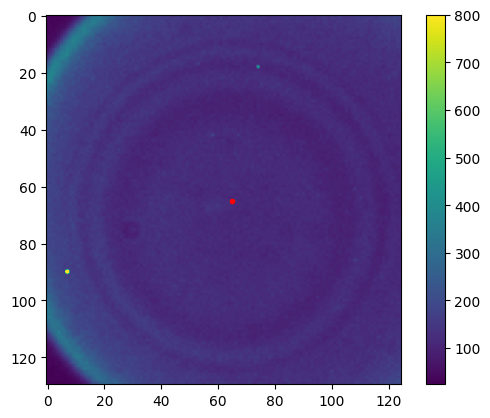

In [122]:
print(df['run_0'].keys())
imgs = df['run_0']['fringes']
roi = [70, 200, 65, 190]
center = [65, 65]

dark_img = df['run_0']['dark_img']
# plt.imshow(dark_img)
plt.imshow(imgs[0][roi[0]:roi[1], roi[2]:roi[3]], vmax=800)
plt.plot(*center, '.r')
plt.colorbar()

In [124]:
visibility = np.fft.rfft(imgs, axis=0)
print(visibility.shape)

(11, 250, 250)


TypeError: Invalid shape (11, 250, 250) for image data

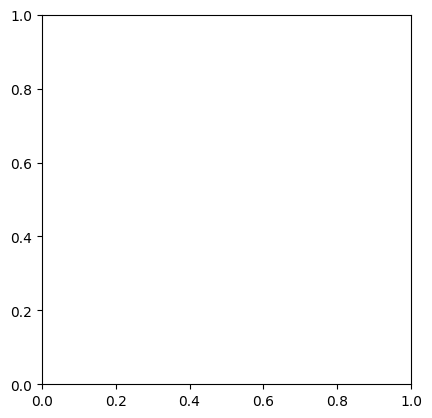

In [127]:
plt.imshow(np.abs(visibility[0]))

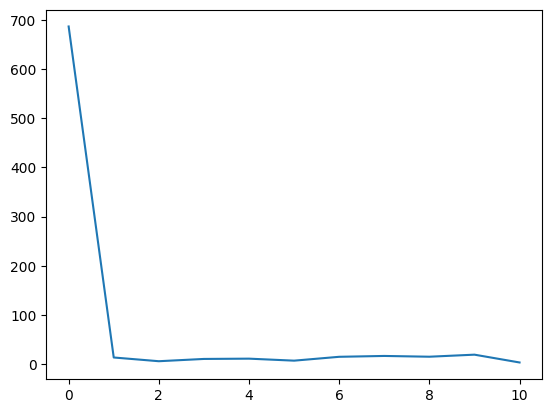

In [126]:
plt.plot(np.abs(visibility[:, 65,65]))

In [7]:
qi.shutdown()

In [10]:
qi.actuator_list['sig_arm_piezo'].set_parameters(100)

Exception in thread Thread-11 (_actions):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/computer/quantum-sensing-auto-alignment/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/computer/quantum-sensing-auto-alignment/app/drivers.py", line 353, in _actions
    while not (int(position) - self._tol <= self._actuator.get_position(channel=axis) <= int(position) + self._tol) and not observed_twice:
                                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/computer/quantum-sensing-auto-alignment/venv/lib/python3.12/site-packages/pylablib/core/utils/general.py", line 1120, in wrapped
    res=func(**all_args)
        ^^^^^^^^^^^^^^^^
  File "/home/computer/quantum-sensing-auto-al

KeyboardInterrupt: 

In [11]:
qi.shutdown()

In [1]:
from app.drivers import KIM101

In [2]:
sig_arm_piezo =  KIM101('/dev/ttyUSB3', 'sig_arm_piezo')
sig_arm_piezo.initialise(config_dict={})

In [8]:
sig_arm_piezo.set_parameters(0, axis=1)

In [10]:
sig_arm_piezo.shutdown()

In [9]:
sig_arm_piezo.get_position()

[0, 0]

In [5]:
from app.driver_libs.jena import NV40

In [6]:
nv =  NV40('/dev/ttyUSB7')

AttributeError: 'NV40' object has no attribute 'serial_conn'

In [46]:
nv.set_position(0)

In [47]:
nv.set_remote_control(False)

In [48]:
nv.__exit__(1,1,1)